In [1]:
# Library imports
import numpy as np                        
import pandas as pd                     
import matplotlib.pyplot as plt          
import seaborn as sns                    


In [2]:
# EMA import and Sensitivity Analysis specific import
from ema_workbench import (              
    Samplers,                           
    Policy,                              
    ema_logging,                         
    SequentialEvaluator,                 
    save_results                         
)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem  
from SALib.analyze import sobol          

# Local modules
from dike_model_function import DikeNetwork            
from problem_formulation import get_model_for_problem_formulation  

import copy     

c:\Users\quint\Documents\Ralph\.venv\Lib\site-packages\ema_workbench\em_framework\__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


In [3]:
# Enable logging to monitor EMA Workbench execution
ema_logging.log_to_stderr(ema_logging.INFO)  

<Logger EMA (DEBUG)>

In [ ]:
# Load the model based on a specific policy scenario (formulation 2)
model, steps = get_model_for_problem_formulation(2)
  
# Deep copy uncertainties and levers for manipulation
model_uncertainties = copy.deepcopy(model.uncertainties)  
model_levers = copy.deepcopy(model.levers)
  

In [5]:
  # Set up a baseline policy with all levers set to zero (do nothing)
zero_lever_config = {lever.name: 0 for lever in model_levers}   
baseline_policy = Policy("No Action", **zero_lever_config)
  

In [6]:
  # Perform Sobol sampling experiments with the defined zero-policy
n_samples = 1000 # change to 40000 for full Sobol experiment
  
with SequentialEvaluator(model) as evaluator:                      
    input_scenarios, model_outputs = evaluator.perform_experiments( 
        scenarios=n_samples,
        policies=[baseline_policy],
        uncertainty_sampling=Samplers.SOBOL                     
    )

c:\Users\quint\Documents\Ralph\.venv\Lib\site-packages\scipy\stats\_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 40000 scenarios * 1 policies * 1 model(s) = 40000 experiments
100%|██████████████████████████████████| 40000/40000 [2:07:07<00:00,  5.24it/s]
[MainProcess/INFO] experiments finished


In [7]:
  # Save results for future reuse
save_results((input_scenarios, model_outputs), 'results_sequential.tar.gz') 
  

[MainProcess/INFO] results saved successfully to c:\Users\quint\Documents\Ralph\MBD-repository\results_sequential.tar.gz


In [27]:
  # Construct SALib problem definition from uncertainties
salib_problem = get_SALib_problem(model_uncertainties)
  
  # Perform Sobol sensitivity analysis on key outcome indicators
def perform_sobol_analysis(metric_name):                
    outcome_data = model_outputs[metric_name]           
    return sobol.analyze(                               
        salib_problem,
        outcome_data,
        calc_second_order=True,
        print_to_console=True
    )

sobol_damage = perform_sobol_analysis('Expected Annual Damage')
sobol_deaths = perform_sobol_analysis('Expected Number of Deaths')

# These are of course 0 because we run it under 0 policy
# sobol_dike_costs = perform_sobol_analysis('Dike Investment Costs')
# sobol_rfr_costs = perform_sobol_analysis("RfR Investment Costs")
# sobol_evac_costs = perform_sobol_analysis("Evacuation Costs")
 

c:\Users\quint\Documents\Ralph\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.005914  0.001353
A.1_Bmax                 0.014573  0.005362
A.1_Brate                0.000069  0.000047
A.1_pfail                0.675866  0.062600
A.2_Bmax                 0.000435  0.000489
A.2_Brate                0.000012  0.000011
A.2_pfail                0.026185  0.004727
A.3_Bmax                 0.000314  0.000350
A.3_Brate                0.000006  0.000008
A.3_pfail                0.256974  0.029273
A.4_Bmax                 0.000027  0.000028
A.4_Brate                0.000002  0.000004
A.4_pfail                0.001760  0.000541
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.021884  0.005846
discount rate 0          0.022343  0.002816
discount rate 1          0.022220  0.002948
discount rate 2          0.022385  0.003001
                               S1   S1_conf
A.0_ID flood wave shape -0.000248  0.006055
A.1_Bmax                 0.00148

c:\Users\quint\Documents\Ralph\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.009614  0.002763
A.1_Bmax                 0.032455  0.010573
A.1_Brate                0.000174  0.000120
A.1_pfail                0.265589  0.027544
A.2_Bmax                 0.001071  0.001471
A.2_Brate                0.000027  0.000034
A.2_pfail                0.032060  0.009855
A.3_Bmax                 0.000225  0.000197
A.3_Brate                0.000005  0.000005
A.3_pfail                0.815461  0.072387
A.4_Bmax                 0.000019  0.000021
A.4_Brate                0.000001  0.000003
A.4_pfail                0.001394  0.000578
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.017422  0.003480
discount rate 0          0.000000  0.000000
discount rate 1          0.000000  0.000000
discount rate 2          0.000000  0.000000
                               S1   S1_conf
A.0_ID flood wave shape -0.002745  0.007565
A.1_Bmax                 0.00372

In [22]:
  # Helper function to convert Sobol results to tidy DataFrame
def format_sobol_indices(sobol_result):                            
    selected_keys = ['S1', 'S1_conf', 'ST', 'ST_conf']            
    sobol_df = pd.DataFrame({key: sobol_result[key] for key in selected_keys},  
                             index=salib_problem['names'])       
    return sobol_df.sort_values(by='ST', ascending=False) 
  

In [23]:
  # Plotting function for a single metric

def plot_sobol(df, title_text, ylabel_text):                       
    fig, ax = plt.subplots(figsize=(10, 6))                        
    df[['S1', 'ST']].plot.bar(ax=ax, yerr=df[['S1_conf', 'ST_conf']].T.values, capsize=4)  
    ax.set_title(title_text, fontweight='bold')                 
    ax.set_ylabel(ylabel_text)                                    
    ax.set_xlabel('Model Uncertainties')                          
    ax.legend(['First-order (S1)', 'Total-order (ST)'])           
    plt.xticks(rotation=45, ha='right')                           
    plt.tight_layout()                                            
    sns.despine()                                                 
    plt.show()  
  

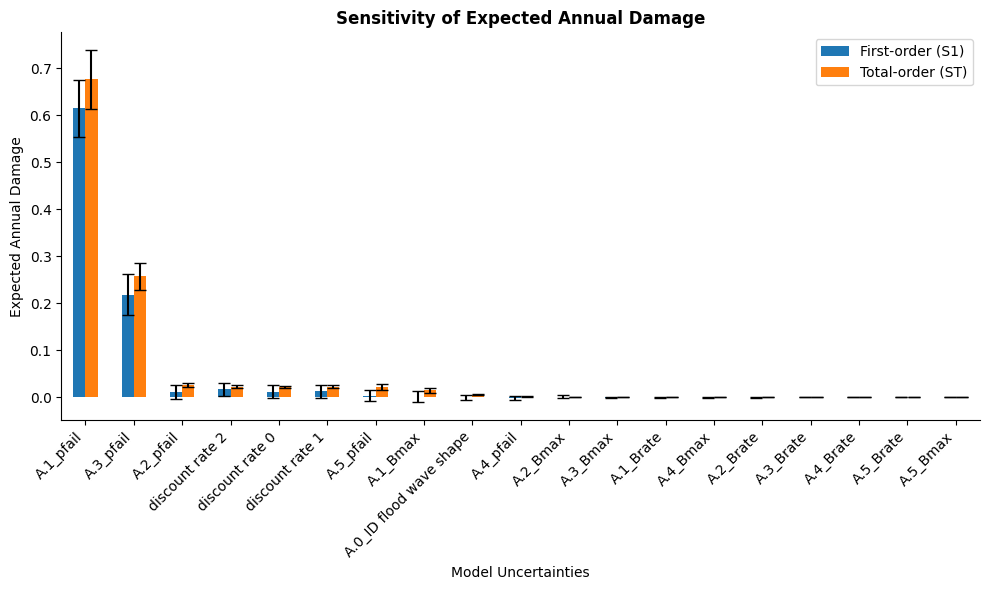

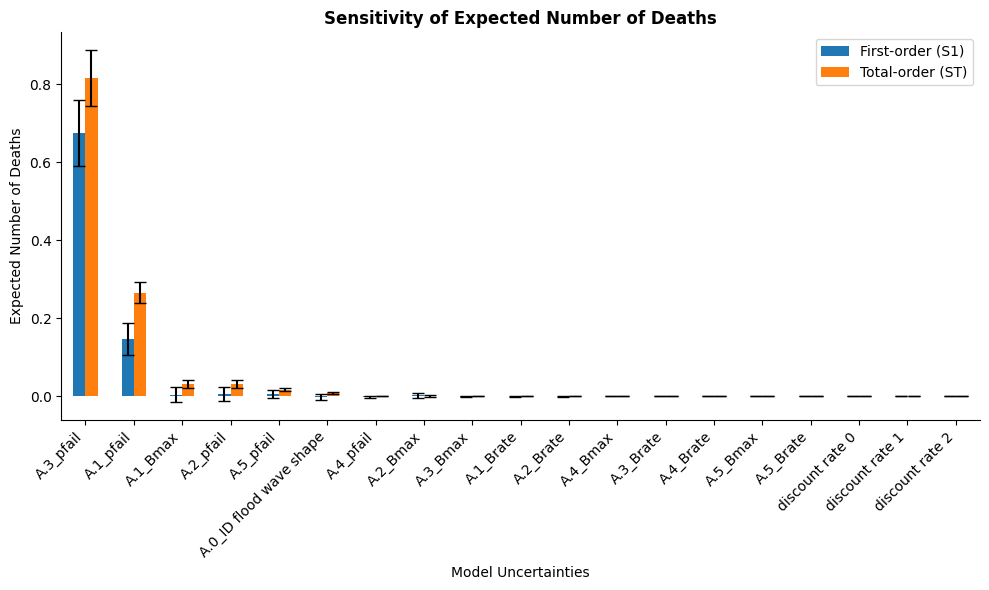

In [28]:
  # Apply plotting to each sensitivity analysis
plot_sobol(format_sobol_indices(sobol_damage),
           'Sensitivity of Expected Annual Damage',
           'Expected Annual Damage')

plot_sobol(format_sobol_indices(sobol_deaths),
           'Sensitivity of Expected Number of Deaths',
           'Expected Number of Deaths')
